In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

do_cpp = True
do_compile = False

In [2]:
# solve model
T = 10
model = brg.HouseholdModelClass(par={'T':T,'phi_w':0.2,'phi_m':0.2,'sigma_love':0.1,'do_cpp':do_cpp})
if do_cpp: model.link_to_cpp(force_compile=do_compile)
    
%time model.solve()

Wall time: 3.91 s


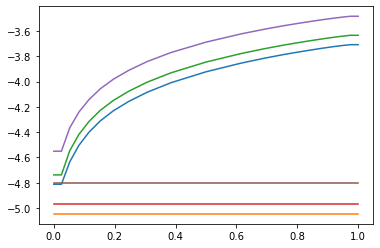

In [3]:
# TODO: 
# 1. check when parameters change..
# WHY ARE THEY NOT OVERLAPPING when sigma_love=0.1!!? I think it must have to do with the very steep slope in the bottom and the grid spacing
# yes: that is why

sol = model.sol
par = model.par
t =  0 #0 #par.T-1 - 1 
iL = 5 # for negative shocks (iL<5), the relationship is doomed..

for iA in [0,10,30]:
    plt.plot(par.grid_power,sol.Vw_couple[t,:,iL,iA]);
    plt.plot(par.grid_power,np.ones(par.grid_power.size)*sol.Vw_single[t,iA]); # the slight difference is from the discrete power grid
    
#     plt.plot(par.grid_power,par.grid_power[sol.power_idx[t,:,iL,iA]],marker='.')
#     plt.plot(par.grid_power,par.grid_power,linestyle='--')

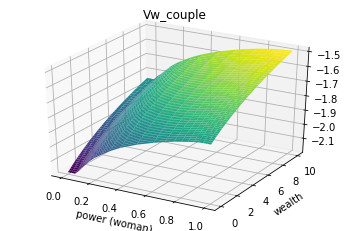

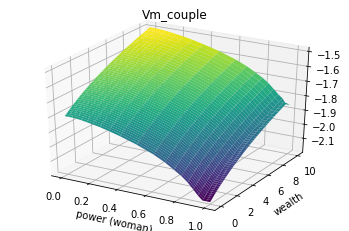

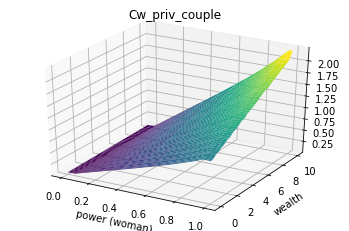

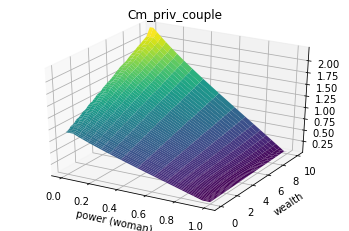

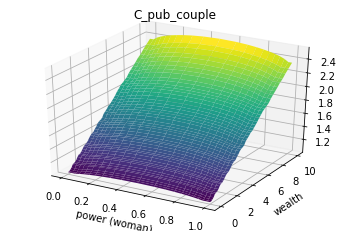

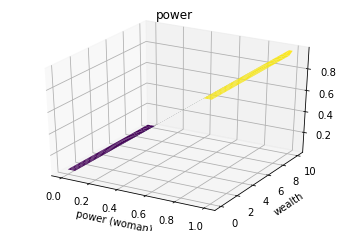

In [4]:
from mpl_toolkits import mplot3d

t = par.T-4
iL = 5
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,:,iL,:]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,:,iL,:]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='power (woman)',ylabel='wealth',title=f'{var}');

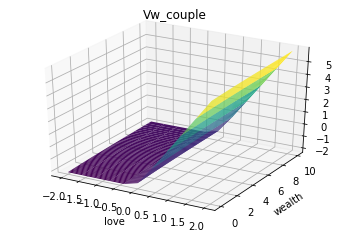

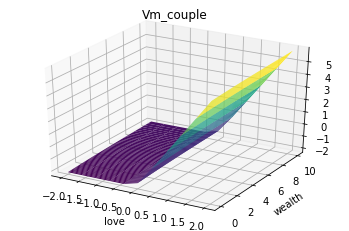

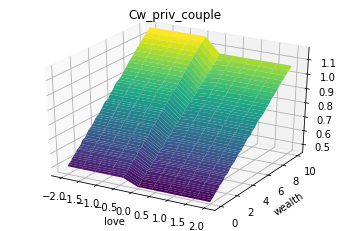

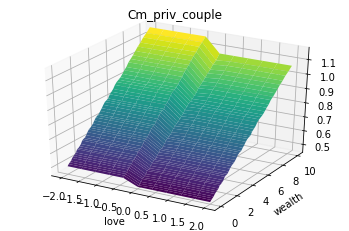

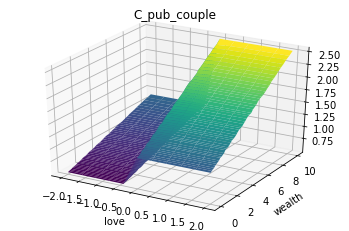

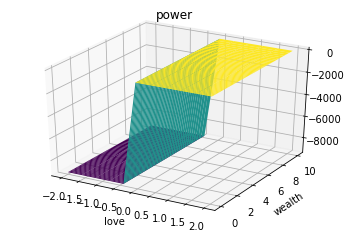

In [5]:
# plot as a function of love and wealth
t = par.T-4
iP = 10
X, Y = np.meshgrid(par.grid_love, par.grid_A,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,iP,:,:]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,iP,:,:]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='love',ylabel='wealth',title=f'{var}');

In [6]:
# %lprun -f model.value_of_choice_couple -f brg.util -f model.indiv_value_of_choice_couple model.solve()

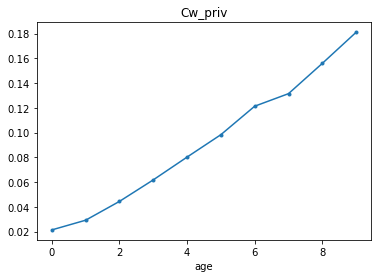

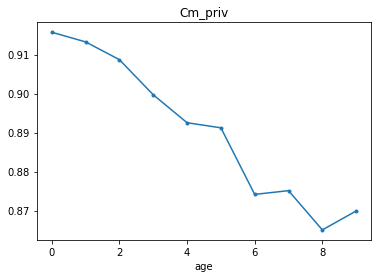

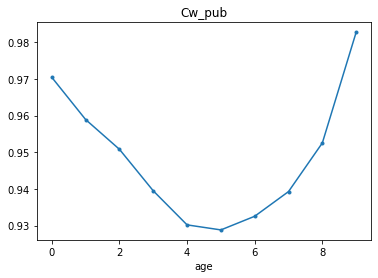

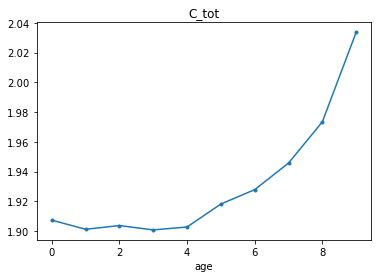

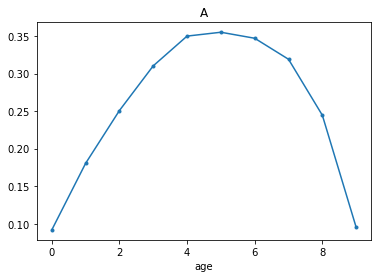

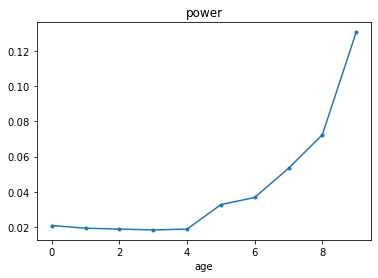

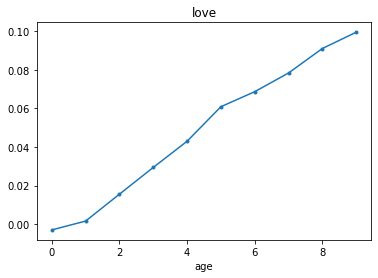

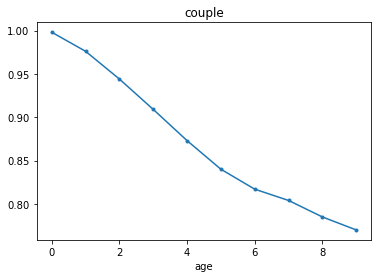

In [7]:
# show how starting of in a low bargaining power gradually improves
model.sim.init_power_idx[:] = 1 
model.sim.init_love[:] = 0.0 # interesting difference: 0.0 vs 0.2   [with sigma_love=0.0]
model.simulate()

for var in ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','love','couple'):

    fig, ax = plt.subplots()
    
    if var == 'C_tot':
        C_tot = model.sim.Cw_priv + model.sim.Cm_priv + model.sim.Cw_pub
        y = np.nanmean(C_tot,axis=0)
    else:
        y = np.nanmean(getattr(model.sim,var),axis=0)

    ax.plot(y,marker='.');
    ax.set(xlabel='age',title=f'{var}');